<a href="https://colab.research.google.com/github/Delaunay-I/image_cap_generator/blob/main/cap_gen_v2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## for google colab runs
%cd /content/drive/MyDrive/colab\ files
!pwd

/content/drive/MyDrive/colab files
/content/drive/MyDrive/colab files


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import sys, time, os, warnings 
import numpy as np
import pandas as pd 
from collections import Counter 

print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))

def set_seed(sd=123):
    from numpy.random import seed
    from tensorflow import set_random_seed
    import random as rn
    ## numpy random seed
    seed(sd)
    ## core python's random number 
    rn.seed(sd)
    ## tensor flow's random number
    set_random_seed(sd)

python 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]
keras version 2.12.0
tensorflow version 2.12.0


In [3]:
!pip install opendatasets
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/adityajn105/flickr8k")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Skipping, found downloaded files in "./flickr8k" (use force=True to force download)


In [4]:
## The location of the Flickr8K_ photos
# dir_Flickr_jpg = "./flickr8k/Images"
dir_Flickr_jpg = "/content/drive/MyDrive/colab files/flickr8k/Images"

## The location of the caption file
# dir_Flickr_text = "./flickr8k/captions.txt"
dir_Flickr_text = "/content/drive/MyDrive/colab files/flickr8k/captions.txt"

jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in Flicker8k: {}".format(len(jpgs)))

The number of jpg flies in Flicker8k: 8091


## Preliminary Analysis

In [5]:
df_txt = pd.read_csv(dir_Flickr_text, skiprows=1, names=["filename", "caption"])
df_txt['caption'] = df_txt['caption'].str.lower()

df_txt['index'] = df_txt.groupby("filename").cumcount()

uni_filenames = np.unique(df_txt.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(df_txt.filename.values).values())

The number of unique file names : 8091
The distribution of the number of captions for each image:


Counter({5: 8091})

In [6]:
import string

# Remove punctuations..
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('', '', string.punctuation))
    return(text_no_punctuation)

# Remove a single character word..
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

# Remove words with numeric values..
def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

In [7]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)


for i, caption in enumerate(df_txt.caption.values):
    newcaption = text_clean(caption)
    df_txt["caption"].iloc[i] = newcaption

<ipython-input-7-0ca6825e3553>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_txt["caption"].iloc[i] = newcaption


In [8]:
def df_word(df_txt):
    vocabulary = []
    for txt in df_txt.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":ct.keys(),"count":ct.values()})
    dfword = dfword.sort_values(by="count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(df_txt)
dfword.head(3)

Vocabulary Size: 8763


,word,count
0,in,18974
1,the,18418
2,on,10743


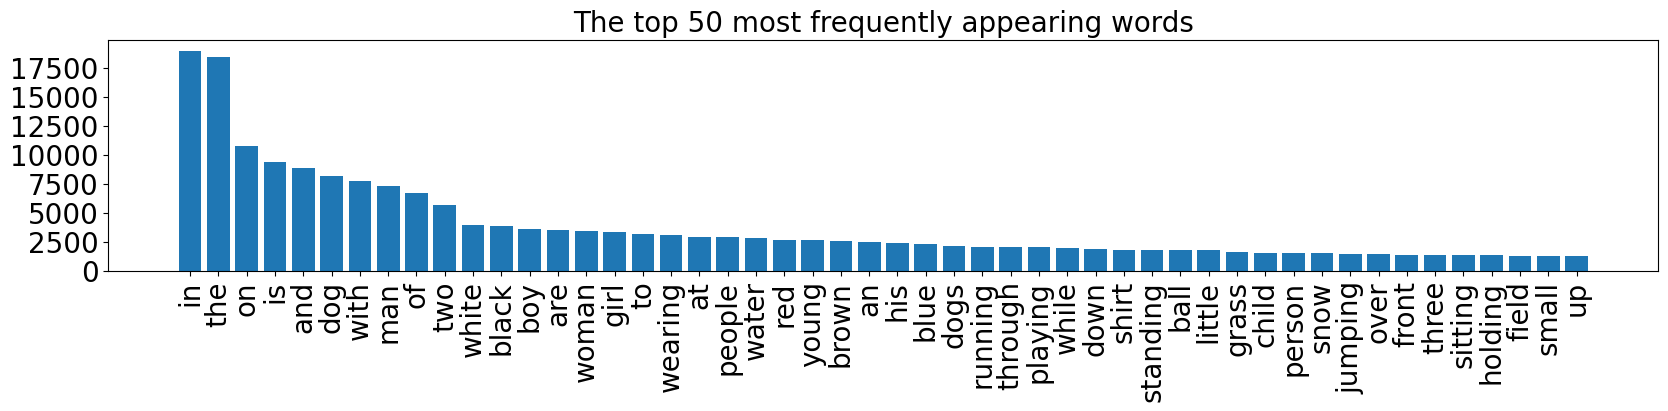

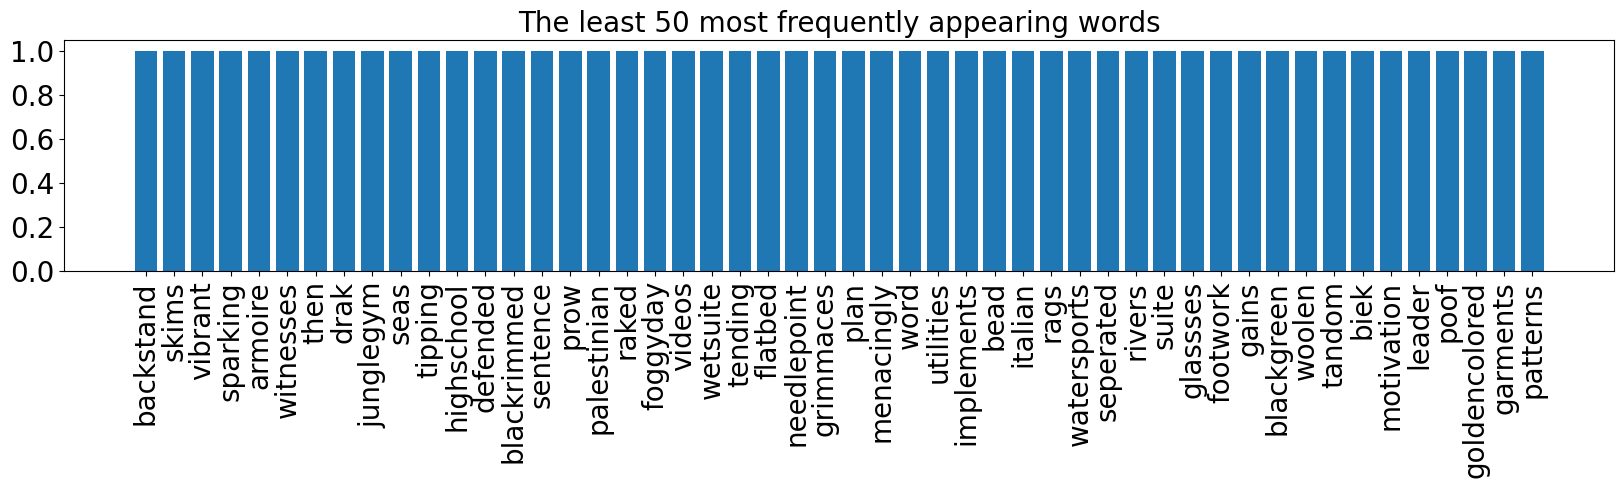

In [9]:
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

# Data prepration
prepare text and image separately

In [10]:
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)

df_txt["caption"] = add_start_end_seq_token(df_txt["caption"])
df_txt.head(5)

,filename,caption,index
0,1000268201_693b08cb0e.jpg,startseq child in pink dress is climbing up s...,0
1,1000268201_693b08cb0e.jpg,startseq girl going into wooden building endseq,1
2,1000268201_693b08cb0e.jpg,startseq little girl climbing into wooden pla...,2
3,1000268201_693b08cb0e.jpg,startseq little girl climbing the stairs to h...,3
4,1000268201_693b08cb0e.jpg,startseq little girl in pink dress going into...,4


# split the dataset int train and test splits

In [11]:
from sklearn.model_selection import train_test_split

# create a list of unique image file names in your DataFrame (df_txt) using the unique method of pandas:
unique_files = df_txt['filename'].unique()

# Split the list of unique file names into train and test sets using the train_test_split function from scikit-learn:
train_files, test_files = train_test_split(unique_files, test_size=0.2, random_state=42)

# Filter the original DataFrame to include only the rows corresponding to the image files in the train and test sets:
train_df = df_txt[df_txt['filename'].isin(train_files)]
test_df = df_txt[df_txt['filename'].isin(test_files)]

# Verify that there is no leakage by checking if there are any image file names that appear in both the train and test sets:
assert len(set(train_df['filename']).intersection(set(test_df['filename']))) == 0
assert train_df.shape[0]/5 == train_df.filename.unique().size
assert test_df.shape[0]/5 == test_df.filename.unique().size

# Image prepration
## create features for image using InceptionV3 model

In [12]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model

base_model = InceptionV3(weights='imagenet')
image_model = Model(inputs = base_model.input, outputs=base_model.layers[-2].output)

In [ ]:
from tensorflow.keras.utils import load_img, img_to_array
from keras.applications.inception_v3 import preprocess_input
import glob
import pickle

train_path = dir_Flickr_jpg
path_all_images = glob.glob(train_path + '/*jpg')

train_img = []  # list of all images in training set
test_img = []
for im in path_all_images:
    file_name = os.path.basename(os.path.normpath(im))
    # include images that only exist in the target directory
    # can split the dataset this way
    if(file_name in train_df.filename.to_list()):
        train_img.append(im)
    elif (file_name in test_df.filename.to_list()):
        test_img.append(im)
    else:
        print(f"{file_name} not in the directory")
    

def preprocess(image_path):
    # inception v3 excepts img in 299 * 299 * 3
    image = load_img(image_path, target_size=(299, 299))
    # convert the image pixels to a numpy array
    x = img_to_array(image)
    # Add one more dimension
    x = np.expand_dims(x, axis = 0)
    x = preprocess_input(x)
    return x

def encode(image_path):
    image = preprocess(image_path)
    vec = image_model.predict(image, verbose=0)
    vec_flattened = vec.flatten()
    return vec_flattened


train_img_feats = {}
test_img_feats = {}

for image in train_img:
    file_name = os.path.basename(os.path.normpath(image))
    train_img_feats[file_name] = encode(image)
for image in test_img:
    file_name = os.path.basename(os.path.normpath(image))
    test_img_feats[file_name] = encode(image)
# Save the image features
with open('train_encoder.pkl', 'wb') as f:
    pickle.dump(train_img_feats, f)
with open('test_encoder.pkl', 'wb') as f:
    pickle.dump(test_img_feats, f)

# Tokenize the captions

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenizer does not limit the number of words
# it still finds all the words in the word_index
# But it will only use the num_words given to encode the text in texts_to_sequences or sequences_to_texts methods
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_df.caption.to_list())

# Add 1 to the vocab size to account for the 0 index used for padding sequences
vocab_size = len(tokenizer.word_index) + 1

# get the word index
train_seqs = tokenizer.texts_to_sequences(train_df.caption.to_list())
test_seqs = tokenizer.texts_to_sequences(test_df.caption.to_list())

# calculate the maximum caption length
max_length = max(len(seq) for seq in train_seqs)

In [ ]:
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.utils import to_categorical

def data_generator(df, tokenizer, max_length, image_data, batch_size, generator_type):
    num_batches = len(df) // batch_size
    while True:
        df = df.sample(frac=1).reset_index(drop=True) # shuffle the data
        for i in range(num_batches):
            batch_df = df.iloc[i*batch_size:(i+1)*batch_size]
            X1, X2, y = [], [], []
            for index, row in batch_df.iterrows():
                try:
                    # try to get the image features from the image_data dictionary
                    pic = image_data[row['filename']]
                except KeyError:
                    # if the file name is not found, print a warning message and skip this row
                    print(f"""Warning ({generator_type} generator):
                          file name {row['filename']} not found in image_data dictionary. Skipping this row.""")
                    continue
                seq = tokenizer.texts_to_sequences([row['caption']])[0]
                for j in range(1, len(seq)):
                    in_seq, out_seq = seq[:j], seq[j]
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=len(tokenizer.word_index)+1)[0]
                    # out_seq = [out_seq]
                    X1.append(pic)
                    X2.append(in_seq)
                    y.append(out_seq)
            yield ([np.array(X1), np.array(X2)], np.array(y))

batch_size = 64
# create data generator for the train set
train_generator = data_generator(train_df, tokenizer, max_length, train_img_feats, batch_size, generator_type="train")

# create data generator for the test set
test_generator = data_generator(test_df, tokenizer, max_length, test_img_feats, batch_size, generator_type="val")

# Downloading GloVe to using its vector embeddings

In [ ]:
import urllib.request
import zipfile

# Set the URL for the GloVe embeddings
url = 'http://nlp.stanford.edu/data/glove.6B.zip'

# Set the path where the embeddings will be stored
embeddings_dir = 'embeddings/glove'

# Create the directory if it doesn't exist
if not os.path.exists(embeddings_dir):
    os.makedirs(embeddings_dir)

# Set the file name for the embeddings archive
embeddings_zip = os.path.join(embeddings_dir, 'glove.6B.zip')

# Download the embeddings archive if it doesn't exist
if not os.path.exists(embeddings_zip):
    print(f'Downloading GloVe embeddings from {url}...')
    urllib.request.urlretrieve(url, embeddings_zip)
    print('Done!')

# Extract the embeddings if they haven't been extracted yet
if not os.path.exists(os.path.join(embeddings_dir, 'glove.6B.100d.txt')):
    print('Extracting GloVe embeddings...')
    with zipfile.ZipFile(embeddings_zip, 'r') as zip_ref:
        zip_ref.extractall(embeddings_dir)
    print('Done!')


In [ ]:
# load GloVe embeddings
embeddings_index = {}
glove_path = "./embeddings/glove/glove.6B.200d.txt"

with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# filter out the words that are not in the top num_words-1 most frequent words
# tokenizer numbers words in the word_index by most repeated
# filtered_word_index = {word: i for word, i in tokenizer.word_index.items() if i <= vocab_size}
# assert len(filtered_word_index) >= vocab_size, f"""the specified vocab size is larger than the tokenizer word_index.
# vocab_size={vocab_size}, length of tokenizer.word_index={len(filtered_word_index)}
# Use smaller vocab size"""

# prepare embedding matrix
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
# index 0 is reserved for padding word_index to be masked by the embedding layer
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

# Define the model

In [ ]:
image_input_values = list(train_img_feats.values())
n_img_features = np.array(image_input_values).shape[1]

In [ ]:
from tensorflow.keras.layers import Dropout, Dense, Embedding, LSTM, Input, add
from keras import backend as K
# Merge model
def define_merge_model(n_img_features, vocab_size, max_length, embedding_dim, embedding_matrix):
    K.clear_session()
    # feature extractor model
    image_input = Input(shape = (n_img_features, ))
    fe1 = Dropout(0.5)(image_input)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    caption_input = Input(shape = (max_length, ))
    embedding_layer = Embedding(vocab_size, embedding_dim,
                                   weights = [embedding_matrix],
                                   input_length = max_length,
                                   mask_zero = False,
                                   trainable = False)(caption_input)
    se2 = Dropout(0.5)(embedding_layer)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[image_input, caption_input], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    # plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [ ]:
next(train_generator)[1].shape

In [ ]:
test_img_feats['805682444_90ed9e1ef3.jpg']

In [ ]:
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, TimeDistributed, Flatten, Multiply, Concatenate,Activation, RepeatVector, Permute, Lambda
from tensorflow.keras.models import Model
from keras import backend as K

def show_attend_tell(n_img_features, vocab_size, max_length, embedding_dim, embedding_matrix):
    # Image input
    inputs1 = Input(shape=(n_img_features,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # Partial caption sequence input
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, embedding_dim, mask_zero=True, weights=[embedding_matrix], trainable=False)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Attention mechanism
    attention_dense1 = Dense(256, activation='relu')(fe2)
    attention_dense2 = Dense(256, activation='relu')(se3)
    attention = attention_dense1 + attention_dense2
    attention = Dense(1, activation='tanh')(attention)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(256)(attention)
    attention = Permute([2, 1])(attention)

    # Apply the attention mechanism
    attended_fe = Multiply()([fe2, attention])
    attended_fe = Lambda(lambda x: K.sum(x, axis=1))(attended_fe)

    # Combine the encoded image and caption using the attention mechanism
    decoder1 = add([attended_fe, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # Model definition
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Print the model summary
    model.summary()

    return model


In [ ]:
# # RNN Decoder
# decoder = Sequential([
#     layers.Input(shape=(None,)),
#     layers.Embedding(vocab_size, embedding_dim, mask_zero=True),
#     layers.LSTM(256, return_sequences=True),
#     layers.Dropout(0.5),
#     layers.LSTM(256, return_sequences=True),
#     layers.Dropout(0.5),
#     layers.LSTM(256, return_sequences=True),
#     layers.Dropout(0.5),
#     layers.TimeDistributed(layers.Dense(256, activation='relu')),
#     layers.TimeDistributed(layers.Dense(vocab_size, activation='softmax'))
# ])

# # Combine Encoder and Decoder
# image_input  = layers.Input(shape = (image_input.shape[1], ))
# fe1 = layers.Dropout(0.2)(image_input )
# features  = layers.Dense(256, activation = 'relu')(fe1)
# caption_input = layers.Input(shape=(max_length,))

# # features = layers.Dropout(0.5)(features)
# sequence = decoder(caption_input)
# sequence = layers.Dropout(0.5)(sequence)
# context = layers.Attention()([features, sequence])
# outputs = layers.concatenate([context, sequence])
# outputs = layers.TimeDistributed(layers.Dense(256, activation='relu'))(outputs)
# outputs = layers.TimeDistributed(layers.Dense(vocab_size, activation='softmax'))(outputs)

# model3 = Model(inputs=[image_input, caption_input], outputs=outputs)

# Train the model

In [ ]:
model_attention = show_attend_tell(n_img_features, vocab_size, max_length, embedding_dim, embedding_matrix)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# define checkpoint callback
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

num_batches = len(train_df) // batch_size
num_val_batches = len(test_df) // batch_size

hist = model_attention.fit(train_generator,
          validation_data=test_generator,
          validation_steps=num_val_batches,
          epochs = 25,
          steps_per_epoch=num_batches,
          verbose = 1,
          callbacks=[checkpoint])

## Saving the model

In [ ]:
with open('model_histpry.pkl', 'wb') as f:
    pickle.dump(hist, f)

In [ ]:
with open('model_histpry.pkl', 'rb') as f:
    hist = pickle.load(f)

In [ ]:
# define some custom metadata for the model
metadata = {
  'name': 'image_caption_generator',
  'description': 'A model that generates captions for images using InceptionV3 and have all the stop words, and with no lemmatization',
  'parameters': {
    'vocab_size': 8000,
    'embedding_dim': 200,
    'lstm_units': 256,
    'beam_size': 5
  },
  'performance': {
    'loss': 1.6700,
    'accuracy': 'Nan',
    'bleu_score': 'NaN'
  }
}

# save the model with the metadata
model_merge.save('capGen_model_v1.5.2.h5')

# Evaluate the model

In [ ]:
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
# generate a description for an image
def generate_desc(model, tokenizer, image_feats, max_length):
    image_feats = image_feats.reshape(1,-1)
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        # predict next word
        yhat = model.predict([image_feats, sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

## BLEU Score

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# evaluate the skill of the model
def evaluate_model(model, df, image_data, tokenizer, max_length):
    actual, predicted = list(), list()
    count = 0 
    # step over the whole set
    for key, image_feats in image_data.items():
        count += 1
        if count % 200 == 0:
            print("  {:4.2f}% is done..".format(100*count/float(df.shape[0]/5)))
        # generate description
        yhat = generate_desc(model, tokenizer, image_feats, max_length)
        # append all the captions of a image file to a list
        caption_list = list()
        for desc in test_df.loc[df["filename"] == key, "caption"]:
            caption_list.append(desc)
        # store actual and predicted
        references = [d.split() for d in caption_list]
        actual.append(references)
        predicted.append(yhat.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
evaluate_model(model_merge, test_df, test_img_feats, tokenizer, max_length)

# Predicting a caption for new image
## greedy search and beam serach

In [ ]:
test_file_dir = dir_Flickr_jpg + '/' + test_df.filename.iloc[0]
true_caption = test_df.caption.iloc[0]
# true_caption = [ tokenizer.index_word[i] for i in tokenizer.texts_to_sequences([true_caption])[0] ] 
print(f"filename: {test_file_dir}\ncaption {true_caption[1:-1]}")
test_img_feats[test_df.filename.iloc[0]]

from PIL import Image

# Load an image
img = Image.open(test_file_dir)
plt.imshow(img)


In [ ]:
def predict_greedy_search(image_path, model):
    # encode the image
    image_vec = encode(image_path)
    # reshape the vector, because our batch only includes 1 file prediction
    image_vec = image_vec.reshape(1, -1)
    # initialize the caption with the start token
    caption = [tokenizer.word_index['startseq']]
    # loop until the end token or the maximum length is reached

    for i in range(max_length):
        padded_caption = pad_sequences([caption], maxlen=22, padding='post')
        # predict the next word using the model
        prediction = model.predict([image_vec, padded_caption], verbose=0)
        # get the word with the highest probability
        word_index = np.argmax(prediction)
        # append the word to the caption
        caption.append(word_index)
        # break if the end token is reached
        if word_index == tokenizer.word_index['endseq']:
            break
    # convert the caption indices to words
    caption_words = [tokenizer.index_word[i] for i in caption]
    # join the words to form a sentence
    caption_sentence = ' '.join(caption_words[1:-1])
    return caption_sentence

test_file_dir = dir_Flickr_jpg + '/' + test_df.filename.iloc[0]
generated_caption = predict_greedy_search(test_file_dir, model_merge)
print(generated_caption)

In [ ]:
def predict_beam_search(image_path, beam_width, tokenizer, model):
    # encode the image
    image_vec = encode(image_path)
    image_vec = image_vec.reshape(1, -1)
    # initialize the caption with the start token
    caption = tokenizer.texts_to_sequences(["startseq"])[0]
    # initialize beam search
    beam = [(caption, 0)]
    
    # loop until the end token or the maximum length is reached
    for i in range(max_length):
        # generate new candidates
        candidates = []
        for j in range(len(beam)):
            seq, score = beam[j]
            # check if the sequence ends with endseq
            if seq[-1] == tokenizer.word_index["endseq"]:
                candidates.append((seq, score))
                continue
            # predict the next word using the model
            padded_caption = pad_sequences([seq], maxlen=max_length, padding='post')
            prediction = model.predict([image_vec, padded_caption], verbose=0)[0]
            # get the top k words with the highest probability
            top_k = prediction.argsort()[-beam_width:][::-1]
            # add new candidates to the list
            for w in top_k:
                new_seq = seq + [w]
                new_score = score + np.log(prediction[w])
                candidates.append((new_seq, new_score))
        # select top k candidates
        beam = sorted(candidates, key=lambda x: x[1], reverse=True)[:beam_width]
        
    # select the best candidate
    seq, score = beam[0]
    # convert the caption indices to words
    caption_words = tokenizer.sequences_to_texts([seq])[0].split()
    # join the words to form a sentence
    caption_sentence = ' '.join(caption_words[1:-1])
    return caption_sentence

In [ ]:
test_file_dir = dir_Flickr_jpg + '/' + test_df.filename.iloc[0]

generated_caption = predict_beam_search(test_file_dir, 10, tokenizer, model=model_old)
print(generated_caption)

# Model 2, more complicated
* You can use a bidirectional LSTM instead of a single LSTM for the caption encoder. This way, you can capture the context from both directions of the caption sequence, and generate more coherent captions.

* You can use an attention mechanism to allow the decoder to focus on different parts of the image and the caption encoder outputs at each time step. This way, you can generate more relevant and informative captions that align with the image content.

* You can use a scheduled sampling technique to train the decoder with a mix of ground truth and predicted words. This way, you can reduce the exposure bias and improve the generalization ability of the decoder.

* You can use a beam search instead of a greedy search for generating captions. This way, you can explore more possible captions and choose the one with the highest probability.

In [ ]:
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Attention

# define the model
ip1 = layers.Input(shape = (2048, ))
fe1 = layers.Dropout(0.2)(ip1)
fe2 = layers.Dense(256, activation = 'relu')(fe1)
ip2 = layers.Input(shape = (max_length, ))
se1 = layers.Embedding(vocab_size, embedding_dim, mask_zero = True)(ip2)
se2 = layers.Dropout(0.2)(se1)
se3 = Bidirectional(layers.LSTM(256, return_sequences=True))(se2) # use bidirectional LSTM
decoder1 = layers.add([fe2, se3[:, -1]]) # use last hidden state of bidirectional LSTM
decoder2 = layers.Dense(256, activation = 'relu')(decoder1)
attn_layer = Attention() # use attention layer
context_vector, attention_weights = attn_layer([decoder2, se3]) # get context vector and attention weights
decoder3 = layers.Dense(256, activation='relu')(context_vector) # use context vector for final dense layer
outputs = layers.Dense(vocab_size, activation = 'softmax')(decoder3)
model_v2 = Model(inputs = [ip1, ip2], outputs = outputs)

model_v2.layers[3].set_weights([embedding_matrix])
model_v2.layers[3].trainable = False
model_v2.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

num_batches = len(df_txt0) // batch_size
model_v2.fit(train_generator, epochs = 50, steps_per_epoch=num_batches, verbose = 1)